## Lecture 9

#### Announcements

* Midterm exam coming up Thursday after break!
    * Covers material through today
    * You can bring one double-sided 8.5x11" sheet of hand-written notes.
* P2 is out! All necessary material will be wrapped up this week.


#### Goals
* Know how to find a least-squares best-fit transformation for:
  * homography (with caveats)
* Understand the Random Sample Consensus (RANSAC) algorithm
* Know how to resample images using forward and inverse
  warping (and why the latter is usually preferred)
* Understand how to perform bilinear interpolation

In [1]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

#### Plan

* Outlier robustness: RANSAC
* Warping: forward and inverse
* Bilinear interpolation

### Context: Panorama Stitching Overview

* [x] Detect features - Harris corners
* [x] Describe features - MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences
    * [x] Translation
    * [x] Affine
    * [x] Projective
    * [ ] **Robustness to outliers - RANSAC**
* Warp image(s) into common coordinate system and blend
    * [ ] **Inverse warping**
    * [ ] Blending
    * [ ] 360 panoramas?

Recall our definition of the optimal transformation for a given set of correspondences is the one that **minimizes** the sum of squared residuals:
$$
\min_T \sum_i||(T\mathbf{p}_i - \mathbf{p}_i')||^2
$$


##### Homework Problem 1

Write down the $x$ and $y$ residuals for a pair of corresponding points $(x, y)$ in image 1 and $(x', y')$ in image 2 under a homography (projective) motion model. Assume the homography matrix is parameterized as
$$
\begin{bmatrix}
  a & b & c\\
  d & e & f\\
  g & h & 1
\end{bmatrix}
$$

TL;DM (too long; didn't math):

* Decompose $A$ using the SVD:
  $$
  U_{m \times m}, \Sigma_{m\times n}, V^T_{n \times n} = \mathrm{SVD}(A_{m \times n})
  $$
* The optimal vector $x^* = $ the row of $V^T$ (column of $V$) corresponding to the smallest element of $\Sigma$ (which is diagonal)
* Usually your linear algebra library will order things so that $\Sigma$'s elements are in descending order, so in practice $x^* = $ the last row of $V^T$ is the optimal $x*$

### Next up: Robustness to outliers

![](../data/outliers.png)

### Next steps: set up for some experiments

We'll need:
- random matches
- code that can estimate a transformation
- code that can apply a transformation

Get this working in the noise-free case. Then we're ready to start the main topic of today.

In [2]:
# Demo:
img_w = 600
img_h = 480
T_gt = np.array(
    [[1, 0, 70],
     [0, 1, -30],
     [0, 0, 1]]
)

# points in left image, row/col pixel coords
n_inlier_matches = 16
pts_L = np.vstack([
    np.random.randint(0.2*img_h, 0.8*img_h, n_inlier_matches),
    np.random.randint(0.2*img_w, 0.8*img_w, n_inlier_matches),
])
pts_L.shape

(2, 16)

In [3]:
def apply_T(pts, T):
    # pts is a 2-by-n matrix of 2D image coords
    # T is a 3-by-3 transformation matrix
    n = pts.shape[1]

    # add a one to each vector
    pts = np.vstack([pts, np.ones(n)])
    pts_T = T @ pts # multiply by T

    # divide by third row and drop it
    pts_T = pts_T[0:2,:] / pts_T[2,:]
    return pts_T

pts_R = apply_T(pts_L, T_gt)
print(pts_R.shape)

(2, 16)


In [4]:
def fit_translation_model(pts_L, pts_R):
    """return a 3x3 matrix T that maps coords in img_L to
    their matching coords in img_R"""
    diff = pts_R - pts_L
    avg_diff = np.sum(diff, axis=1) / pts_L.shape[1]
    T = np.identity(3)
    T[0:2,2] = avg_diff
    return T

In [5]:
# check: does it work?
apply_T(pts_L, T_gt) - pts_R

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [20]:
from matplotlib.patches import Rectangle, Polygon

def visualize_matches(pts_L, pts_R, img_w, img_h,
                      match_colors=None,
                      img_outer_pad = 60,  # border around images
                      img_inner_pad = 100, # space between images
                      ax=None
                     ):
    
    # define global to local coords transforms for both images
    def L2g(pts_L):
        # pts_L coords are (row,col) with (0,0) in upper left
        assert len(pts_L.shape) == 2 and pts_L.shape[0] == 2
        return np.vstack([
            pts_L[1,:] + img_outer_pad,
            img_h + img_outer_pad - pts_L[0,:]
        ])
    def R2g(pts_R):
        # pts_R coords are (row,col) with (0,0) in upper left
        assert len(pts_R.shape) == 2 and pts_R.shape[0] == 2
        return np.vstack([
            pts_R[1,:] + img_outer_pad + img_inner_pad + img_w,
            img_h + img_outer_pad - pts_R[0,:]
        ])

    # Axis setup
    if ax is None:
        fig = plt.figure(figsize=(12,4))
        ax = plt.gca()
    viz_w = 2*img_outer_pad + img_inner_pad + 2 * img_w
    viz_h = 2*img_outer_pad + img_h
    ax.axis('off')
    ax.add_patch(Rectangle((0, 0), viz_w, viz_h, color='#f2f2f2')) #background grey
    ax.set_xlim(0, viz_w)
    ax.set_ylim(0, viz_h)
    ax.set_aspect('equal')


    # plot elements, in local image coords
    img_frame = np.array([
        [0, 0,       img_h-1, img_h-1],
        [0, img_w-1, img_w-1, 0      ]
    ])
    text_loc = np.array([[img_h + 10],[img_w/2]])

    # draw image frames and keypoint points
    ax.add_patch(Polygon(L2g(img_frame).T, closed=True, fill=False, edgecolor='k'))
    ax.add_patch(Polygon(R2g(img_frame).T, closed=True, fill=False, edgecolor='k'))
    ax.text(*L2g(text_loc), "Left Image",  ha='center', va='top')
    ax.text(*R2g(text_loc), "Right Image", ha='center', va='top')
    ax.plot(*L2g(pts_L), '.k', markersize=8)
    ax.plot(*R2g(pts_R), '.k', markersize=8)
    
    # add lines between matches
    for i in range(pts_L.shape[1]):
        c = 'g' if match_colors is None else match_colors[i]
        pL = L2g(pts_L)[:,i]
        pR = R2g(pts_R)[:,i]
        ax.plot([pL[0], pR[0]], [pL[1], pR[1]], '-', color=c, linewidth=0.5)
    
    plt.show()

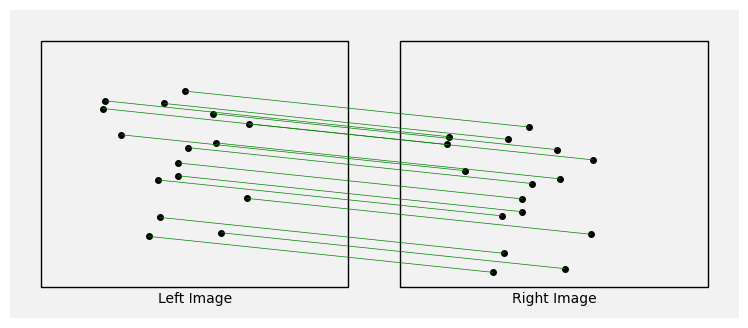

In [7]:
visualize_matches(pts_L, pts_R, img_w, img_h)

#### Where are we at?

- We can create a noise-free matching problem.
- we can solve it
- Pretty picture convince us that this works

#### Next task: again, but make some noise!
- create noisy matches
- fit a transform
- measure how well it worked
- visualize?

In [8]:
def visualize_model(pts_L, pts_R, model, img_w, img_h,
          match_colors=None,
          img_outer_pad = 60,  # border around images
          ax=None
         ):
    
    # define global to local coords transforms for both images
    def I2g(pts):
        # pts_L coords are (row,col) with (0,0) in upper left
        assert len(pts.shape) == 2 and pts.shape[0] == 2
        return np.vstack([
            pts[1,:] + img_outer_pad,
            img_h + img_outer_pad - pts[0,:]
        ])

    # Axis setup
    if ax is None:
        fig = plt.figure(figsize=(12,4))
        ax = plt.gca()
    viz_w = 2*img_outer_pad + img_w
    viz_h = 2*img_outer_pad + img_h
    ax.axis('off')
    ax.add_patch(Rectangle((0, 0), viz_w, viz_h, color='#f2f2f2')) #background grey
    ax.set_xlim(0, viz_w)
    ax.set_ylim(0, viz_h)
    ax.set_aspect('equal')


    # plot elements, in local image coords
    img_frame = np.array([
        [0, 0,       img_h-1, img_h-1],
        [0, img_w-1, img_w-1, 0      ]
    ])
    text_loc = np.array([[img_h + 10],[img_w/2]])

    # map left points into right image via model. Put into viz coords (g)
    pts_R_g       = I2g(pts_R)
    pts_R_model_g = I2g(apply_T(pts_L, model))

    # draw image frames and keypoint points
    ax.add_patch(Polygon(I2g(img_frame).T, closed=True, fill=False, edgecolor='k'))
    ax.text(*I2g(text_loc), "Right Image", ha='center', va='top')
    ax.plot(*pts_R_g, '.k', markersize=8)
    ax.plot(*pts_R_model_g, '.', color='purple', markersize=8)

    
    # add lines between matches
    for i in range(pts_R.shape[1]):
        c = 'purple' if match_colors is None else match_colors[i]
        pt_pred = pts_R_model_g[:,i]
        pt_real = pts_R_g[:,i]
        ax.plot([pts_R_model_g[0], pts_R_g[0]], 
                [pts_R_model_g[1], pts_R_g[1]], 
                '-', color=c, linewidth=0.5)
    
    plt.show()

[[ 1.          0.         67.46043658]
 [ 0.          1.         -5.96438791]
 [ 0.          0.          1.        ]]


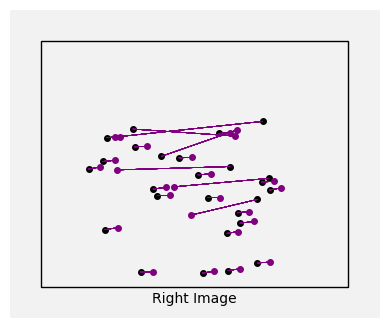

In [18]:
model = fit_translation_model(pts_L, pts_R)
print(model)
visualize_model(pts_L, pts_R, model, img_w, img_h)

In [13]:
"""
Plan: take the experiment above, fold it into a function.
Add a feature: noisy matches
"""
def make_noisy_match_data(num_inlier_matches, 
                          num_outlier_matches,
                          T_gt, img_w, img_h, sigma):

    # points in left image, row/col pixel coords
    pts_L = np.vstack([
        np.random.randint(0.2*img_h, 0.8*img_h, num_inlier_matches),
        np.random.randint(0.2*img_w, 0.8*img_w, num_inlier_matches),
    ])
    pts_L = pts_L.astype(np.float32)
    pts_R = apply_T(pts_L, T_gt)

    pts_L += np.random.normal(0, sigma, size=pts_L.shape)
    pts_R += np.random.normal(0, sigma, size=pts_R.shape)

    pts_L_outlier = np.vstack([
        np.random.randint(0.2*img_h, 0.8*img_h, num_outlier_matches),
        np.random.randint(0.2*img_w, 0.8*img_w, num_outlier_matches),
    ])
    pts_R_outlier = np.vstack([
        np.random.randint(0.2*img_h, 0.8*img_h, num_outlier_matches),
        np.random.randint(0.2*img_w, 0.8*img_w, num_outlier_matches),
    ])
    
    pts_L = np.concatenate((pts_L, pts_L_outlier), axis=1)
    pts_R = np.concatenate((pts_R, pts_R_outlier), axis=1)
    
    return pts_L, pts_R

In [14]:
def score_a_model(pts_L, pts_R, model):
    # TODO: write this
    return -1

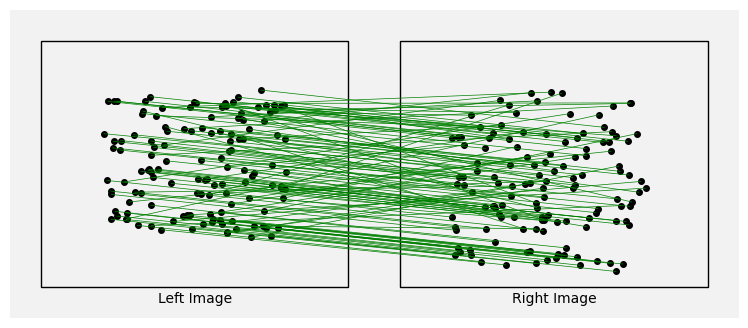

model: [[  1.           0.          39.69674428]
 [  0.           1.         -30.10584905]
 [  0.           0.           1.        ]]
score: -1


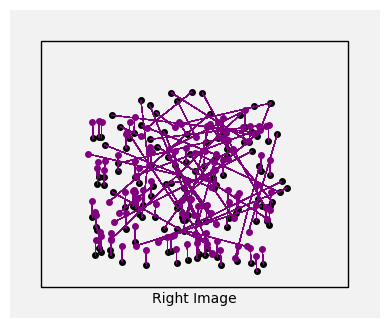

In [22]:
img_w = 600
img_h = 480
num_inlier_matches = 80
num_outlier_matches= 50
sigma_px = 1
T_gt = np.array(
    [[1, 0, 70],
     [0, 1, -30],
     [0, 0, 1]]
)

pts_L, pts_R = make_noisy_match_data(num_inlier_matches, num_outlier_matches, T_gt, img_w, img_h, sigma_px)
visualize_matches(pts_L, pts_R, img_w, img_h)

model = fit_translation_model(pts_L, pts_R)
print('model:', model)
print('score:', score_a_model(pts_L, pts_R, model))
visualize_model(pts_L, pts_R, model, img_w, img_h)


#### RANSAC: RAndom SAmple Consensus

Finding a transformation is a model fitting problem. A simple model fitting problem that we'll use as analogy is **line fitting** (in fact, this is what linear least squares is doing for us, it's just fitting higher-dimensional lines).

**Problem statement**, for now: Given a set of points with some outliers, find the line that fits the non-outliers best.

**Key Idea:** 

> “All good matches are alike; every bad match is bad in its own way.”
> 
> -Tolstoy, as misquoted by Alyosha Efros

**Observation**: If I have a candidate model, I can tell how good it is by measuring how many points "agree" on that model.

Algorithm, take 1:
```
for every possible line:
   count how many points are inliers to that line
return the line with the most inliers
```
Runtime: O($\infty$)


Algorithm, take 2:
```
for every line that goes through two of the given points:
   count how many points are inliers to that line
return the line with the most inliers
```
Runtime: O(n^3)

Algorithm, take 3: RANSAC - see whiteboard notes

##### Homework Problems 2-4

2. In the inner loop of RANSAC, how many points are used to fit a candidate model if you are fitting a line to a set of 2D points?
3. In the inner loop of RANSAC, how many pairs of corresponding points are used to fit a candidate model if you are fitting a translation to a set of correspondences?
4. In the inner loop of RANSAC, how many pairs of corresponding points are used to fit a candidate model if you are fitting a homography to a set of correspondences?

##### Homework Problem 5 (preview)

In this problem, we'll analyze the RANSAC algorithm to help us understand how to decide how many iterations to run ($K$). Suppose we are fitting some model that requires a minimal set of $s$ points to fully determine (e.g., $s=4$ matches for a homography, $s=2$ points for a line). We also know (or have assumed) that the data has an *inlier ratio* of $r = \frac{\text{\# inliers}}{\text{\# data points}}$; in other words, the probability that a randomly sampled point from the dataset as a probability of $r$ of being an inlier.